In [1]:
%run mqtt_thingy.ipynb

In [1]:
%cd ./util_interfaces/
%run advance_dashboard.ipynb

/home/dlar58/Documents/2025_Transformable_Robot/util_interfaces
info
        
        Always be aware that this version of dashboard is instanced when defination.
        Which means that there cannot be two dashboard in the same ipynb kernel.
        
        


Box(children=(Button(description='buttoner', disabled=True, layout=Layout(height='30px', width='auto'), style=…

Box(children=(StateButton(description='loop_timer', layout=Layout(height='30px'), style=ButtonStyle(button_col…

In [2]:
    R=Responder(("10.144.113.5",1885),"ho1_ret")
    R.to="ho1"

NameError: name 'Responder' is not defined

In [4]:
def rett(task):
    k=ipywidgets.Textarea(layout=ipywidgets.Layout(width='500px', height='100px'))
    task.start()
    return (k,)

@TaskHandlerButtonAdvanced.add_to_state_button(s, rett)
async def control_loop(task, sleep_interval=0.05, keep_len=10):
    global actions
    obs = task.widgets[0]
    
    @loop(sleep_interval)
    def go():
        obs.value="\n".join([str(i) for i in R.ret_list][::-1])
    
    # await asyncio.gather(R.loop_recv(),go())
    await asyncio.gather(go())
t=control_loop("control_loop")

Connected successfully!


In [5]:
await asyncio.sleep(0.1)

In [6]:
R.ret_list

[]

In [7]:
s.display()

Box(children=(Button(description='buttoner', disabled=True, layout=Layout(height='30px', width='auto'), style=…

Box(children=(StateButton(description='loop_timer', layout=Layout(height='30px'), style=ButtonStyle(button_col…

Box(children=(StateButton(description='control_loop', layout=Layout(height='30px'), style=ButtonStyle(button_c…

In [8]:
Init = [0,0,0,0,0]
R.send_exe(f"esp.pca_moves({Init})")

In [9]:
import time

In [10]:
# Import required libraries
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp


In [11]:
# #%% Define constants and parameters
# n = 5  # number of oscillators

# # Frequency
# omega_val = 2 * np.pi
# omega = np.ones(n) * omega_val

# # Convergence rate
# mu_const = 1
# mu = np.ones(n) * mu_const

# # Amplitude
# a_val = 10
# a_param = np.ones(n) * a_val

# # Tune the code after these:

# # Rolling
# R_val = 45
# R_amp = np.ones(n) * R_val
# R_amp = np.array([1, -1, -1, 1, 1]) * R_val
# R_amp = np.array([0.8, -0.9, -1, 1.1, 1.2]) * R_val

# # Desired phase differences
# theta_tilde = np.array([np.pi/2, -np.pi/2, np.pi/2, -np.pi/2])

# # Offset values of each motor
# Offsets  = np.array([0, 0, 0, 0, 0])

In [12]:
#%% Define constants and parameters
n = 5  # number of oscillators

# Frequency
omega_val = 2 * np.pi
omega = np.ones(n) * omega_val

# Convergence rate
mu_const = 1
mu = np.ones(n) * mu_const

# Amplitude
a_val = 10
a_param = np.ones(n) * a_val

# Tune the code after these:

# Rolling
R_val = 45
R_amp = np.ones(n) * R_val
R_amp = np.array([1, -1, -1, 1, 1]) * R_val
# R_amp = np.array([3, -2, -1, 0.5, 0.25]) * R_val
# R_amp = np.array([3, -2, -1, 0.5, 0.25]) * R_val


# Desired phase differences
theta_tilde = np.array([np.pi/2, -np.pi/2, np.pi/2, -np.pi/2]) # Turning in place
theta_tilde = np.array([np.pi/2, np.pi/2, np.pi/2, np.pi/2])   # Forward


# Offset values of each motor
Offsets  = np.array([0, 0, 0, 0, 0])

In [13]:
# #%% Define constants and parameters
# n = 5  # number of oscillators

# # Frequency
# omega_val = 2 * np.pi
# omega = np.ones(n) * omega_val

# # Convergence rate
# mu_const = 1
# mu = np.ones(n) * mu_const

# # Amplitude
# a_val = 10
# a_param = np.ones(n) * a_val

# # Tune the code after these:
# # Side-Winding
# R_val = 45
# R_amp = np.array([0.5*R_val, 0*R_val, 1.0*R_val, 0*R_val, -1.5*R_val])

# # Desired phase differences
# theta_tilde = np.array([np.pi/2, 2*np.pi/2, np.pi/2, 0*np.pi/2])

# # Offset values of each motor
# Offsets  = np.array([0, 0, 0, 0, 0])

First 5 desired angle rows (each row corresponds to the outputs of all oscillators):
[[ 0.      0.      0.      0.      0.    ]
 [ 0.0002 -0.0002 -0.0002  0.0002  0.0001]
 [ 0.0018 -0.0015 -0.0015  0.0014  0.0011]
 [ 0.0056 -0.0046 -0.0045  0.0045  0.0035]
 [ 0.012  -0.01   -0.0099  0.0098  0.0077]]


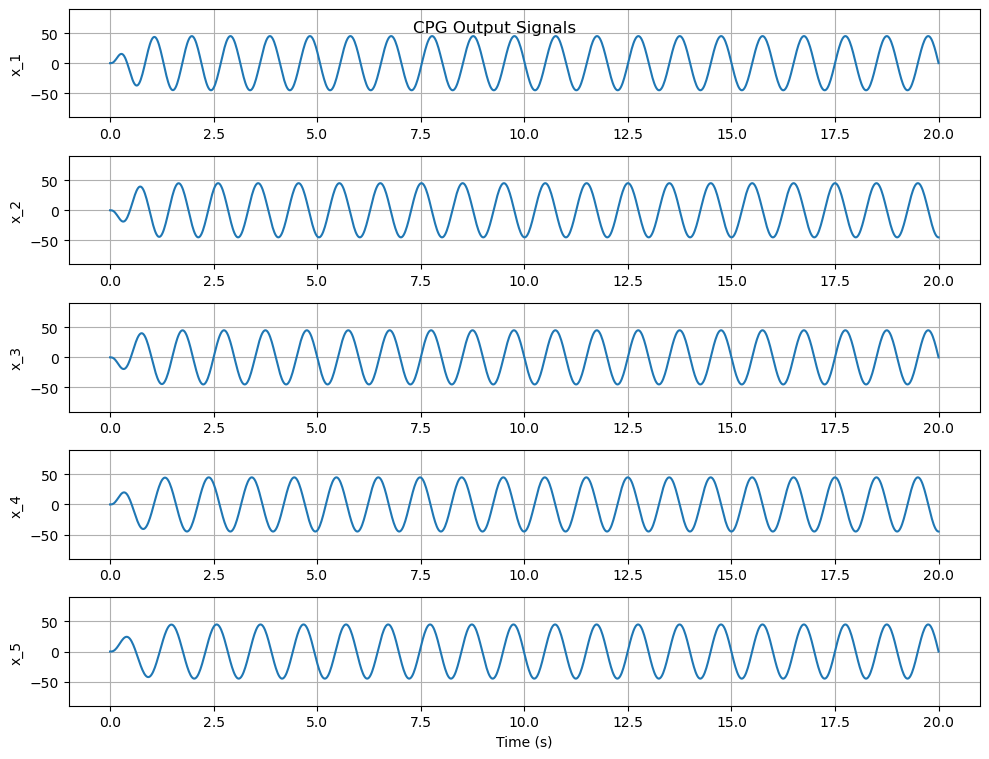

In [14]:
#%% Matrices A and B
A = np.zeros((n, n))
A[0, 0] = -mu[0]
if n >= 2:
    A[0, 1] = mu[1]
for i in range(1, n - 1):
    A[i, i - 1] = mu[i]
    A[i, i]     = -2 * mu[i]
    A[i, i + 1] = mu[i]
A[n - 1, n - 2] = mu[n - 1]
A[n - 1, n - 1] = -mu[n - 1]

B = np.zeros((n, n - 1))
B[0, 0] = 1
for i in range(1, n - 1):
    B[i, i - 1] = -1
    B[i, i]     = 1
B[n - 1, n - 2] = -1

#%% ODE setup
phi0 = np.zeros(n)   # initial phases
r0   = np.zeros(n)   # initial amplitudes
dr0  = np.zeros(n)   # initial amplitude derivatives

x0 = np.concatenate((phi0, r0, dr0))

dt = 0.02  # time step
t_span = (0, 20)  # simulate for 20 seconds
t_eval = np.linspace(t_span[0], t_span[1], int(t_span[1]/dt)) # time points: based on dt and t_span

#%% ODE function definition
def cpgODE(t, x, omega, A, B, theta_tilde, a_param, R_amp, n):
    """
    Compute the derivatives for the CPG system.
    x is [phi, r, dr] with each block of length n.
    Returns: [dphi; dr; ddr]
    """
    phi = x[0:n]
    r   = x[n:2*n]
    dr  = x[2*n:3*n]

    # Phase derivatives
    dphi = omega + A.dot(phi) + B.dot(theta_tilde)

    # Second derivatives for amplitude
    ddr = a_param * ((a_param / 4) * (R_amp - r) - dr)

    # Note: The derivative of r is dr (not r)
    return np.concatenate((dphi, dr, ddr))

#%% Solve the ODE
sol = solve_ivp(
    lambda t, y: cpgODE(t, y, omega, A, B, theta_tilde, a_param, R_amp, n),
    t_span,
    x0,
    t_eval=t_eval
)

t = sol.t
x = sol.y.T  # shape (time_points, 3*n)

#%% Extract the results
phi = x[:, :n]          # phases
r   = x[:, n:2*n]       # amplitudes
dr  = x[:, 2*n:3*n]     # amplitude derivatives



# Compute the rhythmic output signals: x_i = r_i * sin(phi_i)
desired_angle = r * np.sin(phi) + np.ones(phi.shape)*Offsets


normalize_min = -135
normalize_max = 135
# Normalize the output from -1 to 1
desired_angle_normalized = (desired_angle - normalize_min) / (normalize_max - normalize_min) * 2 - 1

# Change the decimal length
desired_angle_normalized = np.round(desired_angle_normalized,4)

#%% Display the first 5 outputs
# print("First 5 time points:", t[:5])
print("First 5 desired angle rows (each row corresponds to the outputs of all oscillators):")
print(desired_angle_normalized[:5, :])

#%% Plot results using columns for each oscillator
plt.figure(figsize=(10, 8))
for i in range(n):
    plt.subplot(n, 1, i+1)
    # Here we plot the i-th column of output, which corresponds to oscillator i+1.
    # plt.plot(t, desired_angle_normalized[:, i], linewidth=1.5)
    plt.plot(t, desired_angle[:, i], linewidth=1.5)
    plt.ylabel(f'x_{i+1}')
    plt.grid(True)
    # plt.ylim(-1, 1) 
    plt.ylim(-90, 90) 
plt.xlabel('Time (s)')
plt.suptitle('CPG Output Signals', y=0.93)
plt.tight_layout()
plt.show()


In [15]:
pps = int(2*np.pi/(phi[11,1]-phi[10,1]))

In [16]:
pps

48

In [17]:
r1 = desired_angle_normalized[:2*pps:1,:].tolist()
R.send_exe(f"esp.ta=loop.create_task(from_li({r1},0.02,1))")

In [18]:
await asyncio.sleep(1)

In [19]:
r1 = desired_angle_normalized[2*pps:4*pps:1,:].tolist()
R.send_exe(f"esp.ta1=loop.create_task(from_li({r1},0.02,1))")

In [20]:
await asyncio.sleep(1)

In [21]:
r1 = desired_angle_normalized[4*pps:6*pps:1,:].tolist()
R.send_exe(f"esp.ta2=loop.create_task(from_li({r1},0.02,1))")

In [22]:
# # For rolling
# sleep_time = 0.5

# for li in desired_angle_normalized[::10]:
#     li=li.tolist()
#     time.sleep(sleep_time)
#     R.send_exe(f"esp.pca_moves({li})")
#     # print(li)

In [23]:
# # For side-winding
# sleep_time = 0.05

# for li in desired_angle_normalized[::1]:
#     li=li.tolist()
#     time.sleep(sleep_time)
#     R.send_exe(f"esp.pca_moves({li})")
#     # print(li)


In [24]:
# # For side-winding 2
# sleep_time = 0.05

# for li in desired_angle_normalized[::1]:
#     li=li.tolist()
#     time.sleep(sleep_time)
#     R.send_exe(f"esp.pca_moves({li})")
#     # print(li)


In [25]:
r1 = desired_angle_normalized[2*pps:4*pps:1,:].tolist()
R.send_exe(f"esp.ta")

In [28]:
R.ret_list

[None, '<Task>']

In [27]:
R1.send_exe(f"esp.ta.cancel()")

NameError: name 'R1' is not defined